# Salary Predictions Based on Job Descriptions

'''This script pulls in salary data, builds and tests several predictive models and then makes salary predictions on test data using the best model.'''
   
__author__ = 'DSDJ Team'
__email__ = 'info@datasciencedreamjob..com'
__website__ = 'www.datasciencedreamjob.com'

__copyright__ = 'Copyright 2018, Data Science Dream Job LLC'

## Identify and Train Best Salary Prediction Regression Model

In [0]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [0]:
def load_file(file):
    '''loads csv to pd dataframe'''
    return pd.read_csv(file)

def consolidate_data(df1, df2, key=None, left_index=False, right_index=False):
    '''perform inner join to return only records that are present in both dataframes'''
    return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)

def clean_data(raw_df):
    '''remove rows that contain salary <= 0 or duplicate job IDs'''
    clean_df = raw_df.drop_duplicates(subset='jobId')
    clean_df = clean_df[clean_df.salary>0]
    return clean_df

def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None, ohe = None):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    if ohe == None:
      ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
      ohe.fit(df[cat_vars])
    cat_df = pd.DataFrame(ohe.transform(df[cat_vars]), columns = ohe.get_feature_names())       
    num_df = df[num_vars].apply(pd.to_numeric)
    df = pd.concat([cat_df, num_df], axis=1)
    return (df, ohe) #,ignore_index=False)

def get_target_df(df, target):
    '''returns target dataframe'''
    return df[target]

def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

def save_results(model, mean_mse, predictions, feature_importances, directory):
    '''saves model, model summary, feature importances, and predictions to directory'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv(directory+'feature_importances.csv') 
    np.savetxt(directory+'predictions.csv', predictions, delimiter=',')

In [4]:
#define working directory
working_dir = '/content/gdrive/My Drive/Colab Notebooks/DSDJ/Salary Prediction/'

#define inputs
train_feature_file = working_dir+'train_features.csv'
train_target_file = working_dir+'train_salaries.csv'
test_feature_file = working_dir+'test_features.csv'

#define variables
categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
numeric_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'

#load data
print("Loading data")
feature_df = load_file(train_feature_file)
target_df = load_file(train_target_file)
test_df = load_file(test_feature_file)

#consolidate training data
raw_train_df = consolidate_data(feature_df, target_df, key='jobId')

#clean, shuffle, and reindex training data -- shuffling improves cross-validation accuracy
clean_train_df = shuffle(clean_data(raw_train_df)).reset_index()

Loading data


In [5]:
#encode categorical data and get final feature dfs
print("Encoding data")
feature_df, ohe = one_hot_encode_feature_df(clean_train_df, cat_vars=categorical_vars, num_vars=numeric_vars)
test_df, _ = one_hot_encode_feature_df(test_df, cat_vars=categorical_vars, num_vars=numeric_vars, ohe = ohe)

#save ohe
joblib.dump(ohe, working_dir+"salary_prediction_ohe.pkl") 

#get target df
target_df = get_target_df(clean_train_df, target_var)

Encoding data


In [0]:
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = -1

#shared model paramaters
verbose_lvl = 0

In [7]:
#create models -- hyperparameter tuning already done by hand for each model
lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
rf = RandomForestRegressor(n_estimators=150, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                           max_features=30, verbose=verbose_lvl)
gbm = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls', verbose=verbose_lvl)
                      
models.extend([lr, lr_std_pca, rf, gbm])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.5077698054613
Standard deviation during CV:
 0.0134707494414954

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 384.573687192433
Standard deviation during CV:
 0.07187213951928584


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Model:
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=60, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Average MSE:
 367.97179039341813
Standard deviation during CV:
 0.4650877987559454

Model:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fra

In [8]:
#choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)

#train model on entire dataset
model.fit(feature_df, target_df)

#create predictions based on test data
predictions = model.predict(test_df)


Predictions calculated using model with lowest MSE:
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [20]:
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature_importances_
    importances = [0]*len(feature_df.columns)
    
feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

#save results
save_results(model, mean_mse[model], predictions, feature_importances, working_dir)

#save model
joblib.dump(model, working_dir+"salary_prediction_model.pkl")

['/content/gdrive/My Drive/Colab Notebooks/DSDJ/Salary Prediction/salary_prediction_model.pkl']

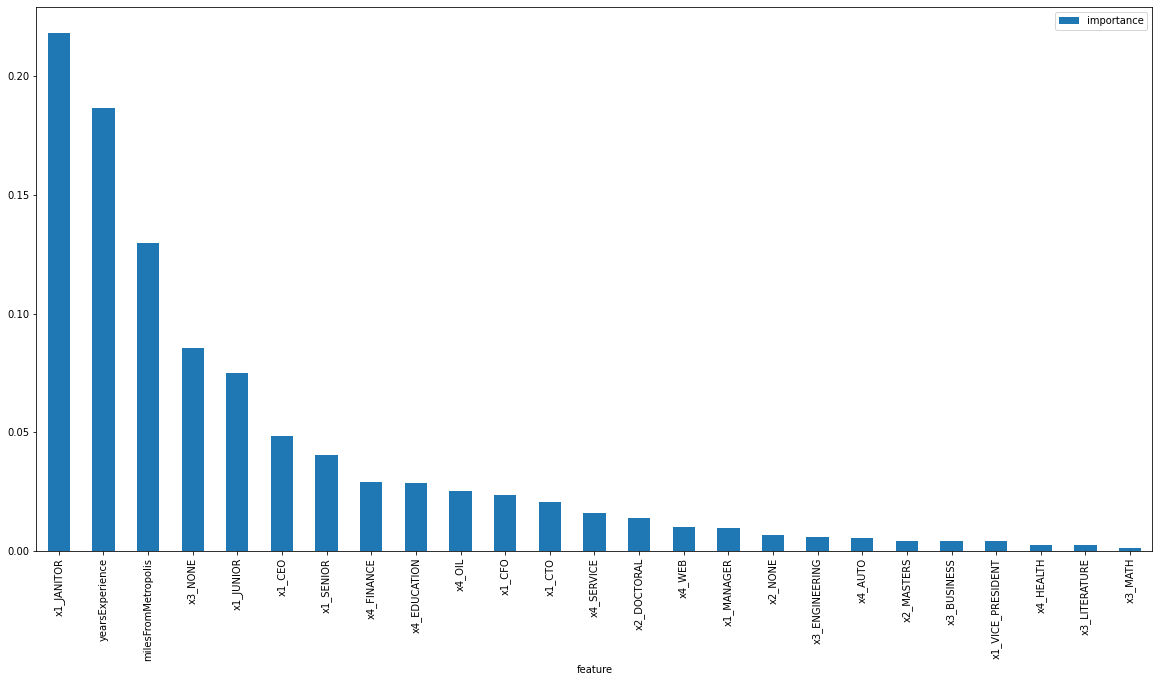

In [16]:
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

In [17]:
!cat model.txt

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
!head '/content/gdrive/My Drive/Colab Notebooks/DSDJ/Salary Prediction/feature_importances.csv'

feature,importance
x1_JANITOR,0.21828490267924294
yearsExperience,0.18671900135088318
milesFromMetropolis,0.12977158342902123
x3_NONE,0.08562541642547082
x1_JUNIOR,0.07476353234840705
x1_CEO,0.048493638362736555
x1_SENIOR,0.040219009242141335
x4_FINANCE,0.028978987406740774
x4_EDUCATION,0.028568660279789704


In [25]:
!head '/content/gdrive/My Drive/Colab Notebooks/DSDJ/Salary Prediction/predictions.csv'

1.112319470299443225e+02
9.358076805149357824e+01
1.789313055117147258e+02
1.043686516871995025e+02
1.170745237113813602e+02
1.507164339871136747e+02
9.642931186092401674e+01
1.185500271711057252e+02
1.069490341265061630e+02
9.826842079587675016e+01
